In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Draw
from rdkit.Chem import Fragments
from ClickReaction import BocRemoval
from ClickReaction import CuAAC
from rdkit.Chem import  Descriptors
from rdkit.Chem.Draw import IPythonConsole
import io
import itertools
from PIL import Image
from ClickReaction import BocRemoval
from tqdm import tqdm
import re
from rdkit.Chem import Lipinski
from rdkit.Chem import Descriptors
from rdkit.Chem import Crippen
import json
import csv
import numpy as np

In [2]:
def replace_specific_pattern(text, pattern, replacement):
    return re.sub(pattern, replacement, text)
rxn = Chem.ReactionFromSmarts('[*:6][C:1]#[C:2].[N-:3]=[N+:4]=[N:5]>>[N:5]1([C:2]=[C:1]([*:6])[N:3]=[N:4]1)')

In [3]:
def convert_primary_amines_to_diazonium(smiles):
    molecule = Chem.MolFromSmiles(smiles)
    primary_amine_pattern = Chem.MolFromSmarts('[NX3;H2]')  
    diazonium_pattern = Chem.MolFromSmiles('[N]=[N+]=[N-]')
    wrong_smiles = Chem.MolFromSmiles('C([N]=[N+]=[N-])[N]=[N+]=[N-]')
    wrong_smiles_2 = Chem.MolFromSmiles('C(=O)[N]=[N+]=[N-]')
    true_smiles = Chem.MolFromSmiles('C(N)N')
    true_smiles_2 = Chem.MolFromSmiles('C(=O)N')
    if molecule.HasSubstructMatch(primary_amine_pattern):
        modified_molecule = Chem.ReplaceSubstructs(molecule, primary_amine_pattern, diazonium_pattern, replaceAll=True)[0]
        if modified_molecule.HasSubstructMatch(wrong_smiles):
            modified_molecule = Chem.ReplaceSubstructs(modified_molecule, wrong_smiles, true_smiles, replaceAll=True)[0]
        elif modified_molecule.HasSubstructMatch(wrong_smiles_2):
            modified_molecule = Chem.ReplaceSubstructs(modified_molecule, wrong_smiles_2, true_smiles_2, replaceAll=True)[0]
        new_smiles = Chem.MolToSmiles(modified_molecule, isomericSmiles=True)
        return new_smiles
    elif '[NH2+]' in smiles:
        try:
            boc_protected_amine = Chem.MolFromSmiles(smiles)
            reaction = BocRemoval(bocamine=boc_protected_amine)
            molecule = reaction.get_product()
            modified_molecule = Chem.ReplaceSubstructs(molecule, primary_amine_pattern, diazonium_pattern, replaceAll=True)[0]
            new_smiles = Chem.MolToSmiles(modified_molecule, isomericSmiles=True)
            return new_smiles
        except:
            # print(smiles,"无法脱Boc")
            return None
    else:
        # print( smiles,"未找到一级胺")
        return None

In [4]:
def convert_diazo_to_triaz( acetylene_smiles,amine_smiles):
    rxn = Chem.ReactionFromSmarts('[*:6][C:1]#[C:2].[N-:3]=[N+:4]=[N:5]>>[N:5]1([C:2]=[C:1]([*:6])[N:3]=[N:4]1)')
    try:
        product = rxn.RunReactants((Chem.MolFromSmiles(amine_smiles), Chem.MolFromSmiles(acetylene_smiles)))
        # jb函数要两个括号
        a=Chem.MolToSmiles(product[0][0])
        if '[N+]=[N-]' in a or '[N-]=[N+]' in a:
            a = replace_specific_pattern(a,r'(?<!N=)\[N\+\]=\[N-\]|(?<!\[N\-\]=)\[N-\]=\[N\+\](?!\=N)','N=N')
        return a
    except:
        # print(amine_smiles,acetylene_smiles,"未找到反应产物")
        return None

In [5]:
def file_imput(file):
    with open(file, 'r') as f:
        lines = f.readlines()
        file_list = [l.split(',')[-10] for l in lines]
    return file_list

In [6]:
def smiles_to_image_grid(smiles_list, img_size=(200, 200), mols_per_row=4, kekulize=True):
    mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]
    if kekulize:
        for mol in mols:
            Chem.Kekulize(mol)
    img = Draw.MolsToGridImage(mols, molsPerRow=mols_per_row, subImgSize=img_size)
    return img

In [7]:
def filter_druglike(mol):
    """
    Filter molecules with druglike rule of 5 in RDKit.
    """
    if Lipinski.NumHDonors(mol) <= 5 and Lipinski.NumHAcceptors(mol) <= 10 and Descriptors.MolWt(mol) <= 500 and Crippen.MolLogP(mol)<=5 and Lipinski.NumRotatableBonds(mol)<=10:
        return True
    else:
        return False

In [8]:
def save_list_to_csv(filename, data_list):
    with open(filename, 'w', newline='', encoding='utf-8') as csvfile:
        csv_writer = csv.writer(csvfile)
        for item in data_list:
            csv_writer.writerow([item])


In [9]:
def load_list_from_csv(filename):
    with open(filename, "r", newline="") as csvfile:
        reader = csv.reader(csvfile)
        return [row for row in reader]

In [10]:
filter_druglike(Chem.MolFromSmiles('CCC'))

True

In [18]:
def is_supported_for_autodock(example_smiles):
    mol = Chem.MolFromSmiles(example_smiles)
    metal_atomic_numbers = [21,22,23,24,25,26,27,28,29,30,31,39,40,41,42,43,44,45,46,47,48,49,72,73,74,75,76,77,78,79,80,81]
    
    # AutoDock要求分子具有至少3个非氢原子
    if mol.GetNumHeavyAtoms() < 3:
        return False

    # 检查金属原子和原子类型
    for atom in mol.GetAtoms():
        atomic_num = atom.GetAtomicNum()

        # 检查金属原子
        if atomic_num in metal_atomic_numbers:
            return False

        # 检查原子类型是否为AutoDock支持的类型
        if atomic_num not in [1, 6, 7, 8, 9, 15, 16, 17, 35, 53]:
            return False

    return True


In [21]:
with open('BiDe_NH2_sele.csv', 'r') as f:
    lines = f.readlines()
amine_smiles_list = []
for i in lines:
    amine_smiles_list.append(i[:-1])

In [22]:
with open ('./BiDe_term_acetylene.csv','r') as f:
    lines = f.readlines()
    acetylene_smiles = [l.split(',') for l in lines]
acetylene_smiles = acetylene_smiles[1:]
acetylene_smiles_list = []
for i in range(len(acetylene_smiles)):
    if float(acetylene_smiles[i][-3]) == 1.0:
        acetylene_smiles_list.append(acetylene_smiles[i][-10])

In [23]:
N3_smiles_list = file_imput('BiDe_N3.csv')[2:]

In [24]:
triazole_smiles_list=[]
for i in amine_smiles_list:
    a=convert_primary_amines_to_diazonium(i)
    N3_smiles_list.append(a)

In [209]:
k = 0
for i in tqdm(N3_smiles_list):
    c = []
    for j in acetylene_smiles_list:
        b=convert_diazo_to_triaz(i,j)
        if filter_druglike(Chem.MolFromSmiles(b)) == True:
            c.append(b)
            k += 1
        else :
            c.append(None)
    triazole_smiles_list.append(c)


100%|██████████| 10077/10077 [1:10:17<00:00,  2.39it/s]


In [11]:
def save_nested_dict_to_json(data, file_name):
    with open(file_name, 'w', encoding='utf-8') as file:
        json.dump(data, file, ensure_ascii=False, indent=4)

In [231]:
save_list_to_csv(triazole_smiles_list, "csv_triazole_smiles.csv")

In [33]:
triazole_smiles_list = load_list_from_csv('csv_triazole_smiles.csv')

In [24]:
save_nested_dict_to_json(triazole_smiles_list, 'json_triazole_smiles_list.json')

In [34]:
matrix_triazole_smiles = np.array(triazole_smiles_list)

In [27]:
with open('acetylene_list.csv', 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerows(acetylene_smiles_list)
with open('N3_list.csv', 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerows(N3_smiles_list)

In [63]:
skip_list_row = []
for i in range(len(triazole_smiles_list)):
    k = 0
    for j in triazole_smiles_list[i]:
        if j == '':
            k += 1
        else:
            pass
    if k > len(triazole_smiles_list[i])/2:
        skip_list_row.append(i)
    elif is_supported_for_autodock(triazole_smiles_list[i][0]) == False:
        skip_list_row.append(i)

In [57]:
skip_list_col = []
for i in range(635):
    k = 0
    for j in range(10077):
        if matrix_triazole_smiles[j][i] == '':
            k += 1
        else:
            pass
    if k > 5039:
        skip_list_col.append(i)
    elif is_supported_for_autodock(matrix_triazole_smiles[0][i]) == False:
        skip_list_col.append(i)

In [62]:
matrix_triazole_smiles[1016][438]

'CC(C)(C)[Si](C)(C)C1=CN(Cc2cc(F)ccc2B(O)O)N=N1'

In [64]:
1016 in skip_list_row

True

In [65]:
import random
import numpy as np

# 设置要从每行和每列中采样的数量
samples_per_row = 3
samples_per_col = 50

sampled_values = []
sampled_values_1 = []

# 按行采样
sampled_sele = {}
for row in range(10077):
    if row in skip_list_row:
        continue
    else:
        a = []
        for col in range(635):
            if matrix_triazole_smiles[row, col] != '' and col not in skip_list_col:
                a.append(col)
        col_indices = random.sample(a, samples_per_row)
        for j in col_indices:
            sampled_sele[f'{row}_{j}'] = matrix_triazole_smiles[row, j]
            sampled_values.append(matrix_triazole_smiles[row, j])

In [59]:
# 按列采样
sampled_sele_1 = {}
for col in range(635):
    if col in skip_list_col:
        continue
    else:
        a = []
        for row in range(10077):
            if matrix_triazole_smiles[row, col] != '' and row not in skip_list_row:
                a.append(row)
        row_indices = random.sample(a, 50)
        for j in row_indices:
            sampled_sele_1[f'{j}_{col}'] = matrix_triazole_smiles[j, col]
            sampled_values_1.append(matrix_triazole_smiles[j, col])

In [66]:
save_nested_dict_to_json(sampled_sele, 'all_NH2.json')
save_nested_dict_to_json(sampled_sele_1, 'all_acetylene.json')

In [50]:
save_list_to_csv('/home/pku/BiDe/N3.csv', N3_smiles_list)


In [51]:
save_list_to_csv('/home/pku/BiDe/acytylene.csv', acetylene_smiles_list)

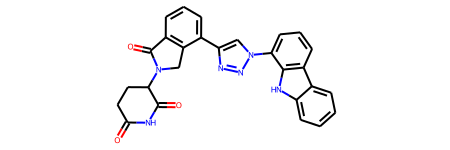

In [2]:
Chem.MolFromSmiles('O=C1CCC(N2Cc3c(cccc3C3=CN(c4cccc5c4[nH]c4ccccc45)N=N3)C2=O)C(=O)N1')